In [1]:
# -*- coding: utf-8 -*-

In [2]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from html_table_parser import parser_functions as parse
from time import sleep
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import random
import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
import lxml
import requests
import html5lib
pd.options.display.max_rows = 50

In [4]:
from bokeh.models import HoverTool, CategoricalColorMapper, OpenURL, TapTool
from bokeh.plotting import ColumnDataSource, figure, output_file, show, save, output_notebook

In [5]:
table_pages = ['https://en.wikipedia.org/wiki/List_of_battles_before_301',
               'https://en.wikipedia.org/wiki/List_of_battles_301%E2%80%931300',
               'https://en.wikipedia.org/wiki/List_of_battles_1301%E2%80%931600',
               'https://en.wikipedia.org/wiki/List_of_battles_since_2001']

In [6]:
list_pages = ['https://en.wikipedia.org/wiki/List_of_battles_1601%E2%80%931800',
               'https://en.wikipedia.org/wiki/List_of_battles_1801%E2%80%931900',
               'https://en.wikipedia.org/wiki/List_of_battles_1901%E2%80%932000',]

In [ ]:
def list_battles(url):
    req = requests.get(url)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    bullets = era_soup.find_all('li')
    
    for bullet in bullets:
        print bullet
        if 'title' in str(bullet):
#             if 'expedition' or 'recapture' or 'capture' or 'war' or 'action' or 'battle' or 'siege' or 'operation' or 'fall' in str(bullet).lower():
#                 if 'List+of+battles' not in str(bullet):
                    if 'footer' not in str(bullet):
                        link = bullet.a['href']
                        link_list.append(link)

                        title = bullet.a['title']
                        title_list.append(title)
                    else:
                        print 'NEXT ENTRY: ' + str(bullet)
#                 else:
#                     print 'NEXT ENTRY: ' + str(bullet)
#             else:
#                 print 'NEXT ENTRY: ' + str(bullet)
        else: 
            print 'NEXT ENTRY' + str(bullet)
                    

In [ ]:
title_list = []
link_list = []
for url in list_pages:
    list_battles(url)

In [ ]:
link_list

In [ ]:
df_late_battles = pd.concat([pd.Series(link_list), pd.Series(title_list)], axis = 1).drop_duplicates()

In [ ]:
df_late_battles = df_late_battles.rename(columns = {0:'url', 1:'Battle'})

In [ ]:
df_late_battles

In [ ]:
df_late_battles[~df_late_battles['Battle'].str.contains('Battle' or 'Operation')]

In [ ]:
df_late_battles.to_csv('battle_list_1600-', encoding = 'utf-8')

In [ ]:
df_late_battles = pd.read_csv('battle_list_1600-.csv', encoding = 'utf-8')

In [ ]:
df_late_battles.head()

In [ ]:
df_late_battles = df_late_battles.drop(['Column1', 'Column4'], axis = 1)
df_late_battles.columns = df_late_battles.iloc[0]
df_late_battles = df_late_battles.drop(0)

In [ ]:
battle_list = []
link_list = []

In [ ]:
def early_battles(link):
    req = requests.get(link)
    print req.status_code
    era = req.content
    era_soup = BeautifulSoup(era)
    tables = era_soup.find_all('table', {'class': 'wikitable'})

    for table in tables:
        cells = table.find_all('td')
        for cell in cells:
            if cell.a is not None:
                a = ['Fall', 'Battle', 'Siege', 'Capture', 'Operation', 'Action', 'Recapture']
                if any(x in str(cell.a['href']) for x in a):
                    battle_list.append(cell.a['title'])
                    link_list.append(cell.a['href'])

In [ ]:
for page in table_pages:
    print page
    early_battles(page)

In [ ]:
df_battles = pd.DataFrame({'battle': battle_list,
                          'link':link_list})

In [ ]:
df_battles = df_battles.rename(columns = {'link':'url', 'battle':'Battle'})

In [ ]:
len(df_battles)

In [ ]:
len(df_late_battles)

In [ ]:
df_battles.head()

In [ ]:
df_url = pd.concat([df_late_battles, df_battles]).reset_index(drop = True)

In [ ]:
len(df_url)

In [ ]:
len(df_url.drop_duplicates())

In [ ]:
s_req = requests.get('https://en.wikipedia.org/Alexander_the_Great')

soup = BeautifulSoup(s_req.text)

ul = soup.find('ul', {'class':'redirectText'})

In [ ]:
if ul is not None:
    print 'works'

In [ ]:
df_battle_all = pd.DataFrame()
df_battle = pd.DataFrame()
def table_scrape(url, name):
#     sleep(1)
    print name
    link = 'https://en.wikipedia.org' + url
    b_req = requests.get(link)

    soup = BeautifulSoup(b_req.text)
    
    bell = soup.find('table', {'class':'infobox vevent'})
    
    if bell is not None:

        details = pd.DataFrame(parse.make2d(bell))
    else:
        return b_req
    

    if 'Belligerents' in str(bell):
    
        clean_rows = details.drop_duplicates(0).set_index(0,drop = True).loc[['Date', 'Location', 'Result'],:]

        clean_col = clean_rows.transpose().reset_index(drop = True)

        df_x_bells = pd.DataFrame()

        html_table = bell.find_all('tr')
        bell_list = []
        bell_y_list = []

        for index, cell in zip(range(0, len(html_table)), html_table):
            if 'Commanders and leaders' in str(cell):
                leaders = html_table[index + 1]
                cells = leaders.find_all('td')
                count = 0
                for cell in cells:
                    count += 1
                    anchors = cell.find_all('a')
                    for anchor in anchors:
                        if 'title' in str(anchor):
                            if 'class="image"' in str(anchor):
                                cl = 'image'
                            elif 'class="thumbborder"' in str(anchor):
                                cl = 'thumb'
                            elif 'cite_note' in str(anchor):
                                cl = 'cite'
                            elif 'disambiguation needed' in str(anchor):
                                cl = 'disam'
                            elif 'cnote_g' in str(anchor):
                                cl = 'cnote'
                            else:
                                title = anchor['title']
                                if any(title == x for x in ['Napoleon I','Alexander III of Macedon']):
                                    print 'napoleon or alex redirect'

                                ref = anchor['href']
                                link = 'https://en.wikipedia.org' + ref

                                if len(ref) <= 10:
                                    t_req = requests.get(link)
                                elif any(ref[8] + ref[9] + ref[10] == x for x in ['pt.', 'tr.', 'ko.', 'ja.', 'th.','da.', 'es.', 'de.', 'it.', 'fr.', 'zh.']):
                                    print 'Not English!'
                                    link = ref
                                    t_req = requests.get(link)
                                elif soup.find('ul', {'class':'redirectText'}) is not None:
                                    print 'REDIRECT'
                                    print title
                                    ul = soup.find('ul', {'class':'redirectText'})
                                    a = ul.a
                                    redirect = a['href']
                                    link = 'https://en.wikipedia.org' + redirect
                                    t_req = requests.get(link)
                                else:
                                    t_req = requests.get(link)

                                t_soup = BeautifulSoup(t_req.text)

                                c_name = t_soup.find('title')
                                c_name = str(c_name)

                                if c_name:
                                    c_name = c_name.replace(' - Wikipedia', '').replace('<title>', '').replace('</title>', '')
                                else:
                                    if count == 1:
                                        bell_list.append(title)
                                    elif count == 2:
                                        bell_y_list.append(title)
                                if 'ex.php?title=' in ref:
                                    ref = ref.replace('ex.php?title=', '')
                                    ref = ref.replace('&action=edit&redlink=1', '')

                                omit_list = ['Capital punishment', 
                                             'Military advisor', 
                                             'Wounded in action', 
                                             'Prisoner of war', 
                                             'Killed in action', 
                                             'Surrender (military)', 
                                             'Surrendered',
                                             'Common military ranks in English']

                                if all(c_name != x for x in omit_list):


                                    if count == 1:

                                        bell_list.append(c_name)
                                    elif count == 2:
                                        bell_y_list.append(c_name)



        for bell in bell_list:
            clean_col['belligerent'] = bell
            df_x_bells = pd.concat([df_x_bells, clean_col])
            df_x_bells = df_x_bells.reset_index(drop = True)


        df_y_bells = pd.DataFrame()
        for bell in bell_y_list:
            clean_col['belligerent'] = bell
            df_y_bells = pd.concat([df_y_bells, clean_col])
            df_y_bells = df_y_bells.reset_index(drop = True)

        df_y_bells = df_y_bells.rename(columns = {0:'Location'})

        if 'Strength' in str(details[0]):
            strength_finder = details[details[0] == 'Strength']


            strength_row = strength_finder.index + 1

            strength = details.loc[strength_row]

            strength_x = strength.iloc[0,0]

            strength_y = strength.iloc[0,1]
        else:
            strength_x = 'unknown'
            strength_y = 'unknown'

        df_x_bells['own'] = strength_x

        df_x_bells['opp'] = strength_y

        df_y_bells['own'] = strength_y

        df_y_bells['opp'] = strength_x

        if 'Casualties and losses' not in str(details[0]):
            df_x_bells['taken'] = np.NaN
            df_x_bells['inflicted'] = np.NaN
            df_y_bells['taken'] = np.NaN
            df_y_bells['inflicted'] = np.NaN

        else:

            casualties_finder = details[details[0] == 'Casualties and losses']

            casualties_row = casualties_finder.index + 1

            casualties = details.loc[casualties_row]

            casualties_x = casualties.iloc[0,0]

            casualties_y = casualties.iloc[0,1]

            df_x_bells['taken'] = casualties_x

            df_x_bells['inflicted'] = casualties_y

            df_y_bells['taken'] = casualties_y

            df_y_bells['inflicted'] = casualties_x



        df_x_bells['Battle'] = name

        df_y_bells['Battle'] = name

        df_x_bells['pos'] = 'L'

        df_y_bells['pos'] = 'R'

        df_battle = pd.concat([df_x_bells, df_y_bells]).reset_index(drop = True)

        df_battle_all = pd.concat([df_battle_all, df_battle]).reset_index(drop = True).drop_duplicates()

        global df_battle_all
    else:
        print 'Filtered: ' + name

In [ ]:
count = 0
for num, rows in {1:df_url[:200],
             2:df_url[200:400], 
             3:df_url[400:600], 
             4:df_url[600:800],
             5:df_url[800:1000],
             6:df_url[1000:1200],
             7:df_url[1200:1400],
             8:df_url[1400:1600],
             9:df_url[1600:1800],
             10:df_url[1800:2000],
             11:df_url[2000:2200],
             12:df_url[2200:2400],
             13:df_url[2400:2600],
             14:df_url[2600:2800],
             15:df_url[2800:3000],
             16:df_url[3000:3200],
             17:df_url[3200:3400],
             18:df_url[3400:]}.iteritems():
    df_battle = pd.DataFrame()
    df_batch = rows
    for index, row in df_batch.iterrows():
        count += 1
        global count
        print str(count) + '/' + str(len(df_url))
        table_scrape(row['url'], row['Battle'])
    df_battle_all.to_csv('rows_{}.csv'.format(num), encoding = 'utf-8')
    print 'NEW FRAME' + str(num)

In [ ]:
row_list = ['rows_1.csv',
 'rows_2.csv',
 'rows_3.csv',
 'rows_4.csv',
 'rows_5.csv',
 'rows_6.csv',
 'rows_7.csv',
 'rows_8.csv',
 'rows_9.csv',
 'rows_10.csv',
 'rows_11.csv',
 'rows_12.csv',
 'rows_13.csv',
 'rows_14.csv',
 'rows_15.csv',
 'rows_16.csv',
 'rows_17.csv',
 'rows_18.csv']

In [ ]:
df_comm = pd.DataFrame()
for sheet in row_list:
    df_rows = pd.read_csv(sheet)
    df_comm = pd.concat([df_comm, df_rows]).reset_index(drop = True)

In [ ]:
df_comm = df_comm.drop('Unnamed: 0', axis = 1)

In [ ]:
len(df_comm)

In [ ]:
len(df_comm)

In [ ]:
df_comm.to_csv('battles_dirty.csv', encoding = 'utf-8')

In [ ]:
df_comm = pd.read_csv('battles_dirty.csv').drop('Unnamed: 0', axis = 1)

In [ ]:
df_comm = df_comm.drop_duplicates()

In [ ]:
df_comm.head()

In [ ]:
len(df_comm)

In [ ]:
df_comm[df_comm.belligerent.str.contains('Nasser')]

In [ ]:
len(df_comm.drop_duplicates())

In [ ]:
df_comm = df_comm.drop_duplicates().reset_index(drop = True)

In [ ]:
df_comm.to_csv('battles_deduped.csv')

In [ ]:
len(df_comm[df_comm.belligerent.str.contains('Napoleon')])

In [ ]:
df_comm[df_comm.belligerent.str.contains('Scipio')]

In [ ]:
df_results = pd.read_csv('result_column.csv')

In [ ]:
df_results[df_results.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm.head()

In [ ]:
df_results.head()

In [ ]:
df_more_results = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'pos', 'Result'])

In [ ]:
df_more_results = df_more_results[df_more_results.VorD.isnull()]

In [ ]:
df_more_results = df_more_results.drop_duplicates(subset = ['Battle', 'Date', 'VorD'])

In [ ]:
df_more_results.head()

In [ ]:
df_more_results.to_csv('adding_results_10.21.csv', encoding = 'utf-8')

In [ ]:
df_comm[df_comm.Battle == 'Battle_of_Camarón']

In [ ]:
df_comm[df_comm.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl = pd.merge(df_comm, df_results, how = 'outer', on = ['Battle', 'belligerent', 'Result', 'pos'])

In [ ]:
df_vl

In [ ]:
df_vl = df_vl.sort('VorD')

In [ ]:
df_vl[df_vl.belligerent == 'Ambroise de Loré']

In [ ]:
df_vl[df_vl.belligerent == 'Saracens']

In [ ]:
df_vl.to_csv('additional_results.csv')

In [ ]:
df_10_21_fill = df_vl[df_vl.VorD.isnull()]

In [ ]:
df_ar = pd.read_csv('additional_results.csv', encoding = 'utf-8')

In [ ]:
df_strength = df_ar.drop(['Unnamed: 0', 'Location', 'Result', 'inflicted', 'taken', 'opp'], axis = 1)

In [ ]:
df_strength = df_strength.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd = df_strength.drop_duplicates(['own', 'pos'], keep = 'first')

In [ ]:
df_strength_dd.own = df_strength_dd.own.str.replace('\r',' ').str.replace('\n', ' ').replace('\n', ' ')

In [ ]:
df_strength_dd = df_strength_dd.sort('Battle').reset_index(drop = True)

In [ ]:
df_strength_dd

In [ ]:
df_strength_dd.to_csv('strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_strength_new = df_strength.drop_duplicates(['own', 'pos', 'Battle'], keep = 'first')

In [ ]:
df_strength_fill = pd.read_excel('strength_entry.xlsx', encoding = 'utf-8')

In [ ]:
df_battles = pd.read_csv('battles_deduped.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [ ]:
df_battles = df_battles.drop(['taken', 'inflicted'], axis = 1)

In [ ]:
df_strength_fill.Battle = df_strength_fill.Battle.str.replace(u"â€“",u'–')

In [ ]:
df_some_strength = pd.merge(df_battles, df_strength_fill, how = 'outer', on = ['Battle', 'pos']).drop(['own_y', 'belligerent_y', 'Date_y'], axis = 1).rename(columns = {'Date_x':'Date','own_x':'own', 'belligerent_x':'belligerent'})

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Battle_of_Jena')]

In [ ]:
df_test = df_some_strength.iloc[:,9:]

In [ ]:
df_str_two = df_some_strength[df_some_strength['Infantry'].isnull() & df_some_strength['Cavalry'].isnull() & df_some_strength['Artillery'].isnull() & df_some_strength['Ships'].isnull() & df_some_strength['Airforce'].isnull() & df_some_strength['Special'].isnull()]

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop_duplicates(['Battle', 'Date', 'Location', 'Result', 'pos']).drop('VorD', axis = 1)

In [ ]:
len(df_str_two)

In [ ]:
df_merger = df_strength.drop(['Date', 'belligerent', 'own'], axis = 1)

In [ ]:
df_merger = df_merger.drop_duplicates()

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = pd.merge(df_str_two, df_merger, on = ['Battle', 'pos'], how = 'outer').dropna(subset = ['Date', 'Location', 'Result'])

In [ ]:
df_str_two = df_str_two.dropna(subset = ['VorD'])

In [ ]:
df_str_two.to_csv('strength_entry_two.csv')

In [ ]:
df_str_two

In [ ]:
df_partial = pd.read_excel('PARTIAL_strength_entry_two.xlsx', encoding = 'utf-8')

In [ ]:
df_str_two.head()

In [ ]:
df_str_two = df_str_two.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], axis = 1)

In [ ]:
df_partial = df_partial.drop(['Date', 'Location', 'Result', 'belligerent','own', 'Column1'],axis = 1)

In [ ]:
df_partial.columns

In [ ]:
df_str_two.head()

In [ ]:
df_finish = pd.merge(df_str_two, df_partial, on = ['Battle', 'pos', 'VorD'], how = 'outer')

In [ ]:
drop_list = list(df_finish[df_finish['Date'].isnull()].index)

In [ ]:
df_finish = df_finish.drop(drop_list)

In [ ]:
df_finish.to_csv('last_strength_entry.csv', encoding = 'utf-8')

In [ ]:
df_some_strength

In [ ]:
df_some_strength[df_some_strength.Battle.str.contains('Siege of La Rochelle')]

In [26]:
df_more_strength = pd.read_excel('last_strength_entry.xlsx')

In [8]:
df_more_strength.head()

,Battle,Date,Location,Result,belligerent,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
0,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\r\r\n52Â°16â€²56â€...",Russian decisive victory,False Dmitry I,23000,L,L,23000,NaN,NaN,NaN,NaN,NaN
1,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\r\r\n52Â°16â€²56â€...",Russian decisive victory,Fyodor Mstislavsky,20000,R,W,20000,NaN,NaN,NaN,NaN,NaN
2,Battle_of_Cape_Rachado,16 to 18 August 1606,"Off Cape Rachado, Portuguese Malacca",Portuguese victory,Martim Afonso de Castro,20 ships,L,V,NaN,NaN,NaN,20.0,NaN,NaN
3,Siege_of_Groenlo_(1606),3â€“14 August 1606 (Spinola)\r\r\r\r\n30 Octob...,"Groenlo, Gelderland\r\r\r\r\n(present-day the ...",1st Siege: Spanish victory\r\r\r\r\n2nd Siege:...,"Ambrogio Spinola, 1st Marquis of the Balbases",15000,L,V,15000,NaN,NaN,NaN,NaN,NaN
4,Siege_of_Troitse-Sergiyeva_Lavra,September 1608 to January 1610,"now Sergiev Posad, Moscow Oblast\r\r\r\r\n56Â°...",Russian victory,Jan Piotr Sapieha,15000,L,D,15000,NaN,NaN,NaN,NaN,NaN


In [9]:
df_some_strength.head()

NameError: name 'df_some_strength' is not defined

In [10]:
df_more_strength = pd.merge(df_more_strength, df_str_two, on = ['Battle', 'pos'], how = 'outer').drop(['own_y', 'Infantry_y', 'Cavalry_y', 'Artillery_y', 'Ships_y', 'Airforce_y', 'Special_y', 'Date_y', 'Location_y', 'Result_y', 'belligerent_y'], axis = 1).dropna(subset = ['Date_x'])

NameError: name 'df_str_two' is not defined

In [11]:
df_more_strength.columns = df_more_strength.columns.str.replace('_x', '')

In [12]:
df_more_strength.head()

,Battle,Date,Location,Result,belligerent,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
0,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\r\r\n52Â°16â€²56â€...",Russian decisive victory,False Dmitry I,23000,L,L,23000,NaN,NaN,NaN,NaN,NaN
1,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\r\r\n52Â°16â€²56â€...",Russian decisive victory,Fyodor Mstislavsky,20000,R,W,20000,NaN,NaN,NaN,NaN,NaN
2,Battle_of_Cape_Rachado,16 to 18 August 1606,"Off Cape Rachado, Portuguese Malacca",Portuguese victory,Martim Afonso de Castro,20 ships,L,V,NaN,NaN,NaN,20.0,NaN,NaN
3,Siege_of_Groenlo_(1606),3â€“14 August 1606 (Spinola)\r\r\r\r\n30 Octob...,"Groenlo, Gelderland\r\r\r\r\n(present-day the ...",1st Siege: Spanish victory\r\r\r\r\n2nd Siege:...,"Ambrogio Spinola, 1st Marquis of the Balbases",15000,L,V,15000,NaN,NaN,NaN,NaN,NaN
4,Siege_of_Troitse-Sergiyeva_Lavra,September 1608 to January 1610,"now Sergiev Posad, Moscow Oblast\r\r\r\r\n56Â°...",Russian victory,Jan Piotr Sapieha,15000,L,D,15000,NaN,NaN,NaN,NaN,NaN


In [13]:
df_some_strength.head()

NameError: name 'df_some_strength' is not defined

In [14]:
df_more_strength

,Battle,Date,Location,Result,belligerent,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
0,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\r\r\n52Â°16â€²56â€...",Russian decisive victory,False Dmitry I,23000,L,L,23000,NaN,NaN,NaN,NaN,NaN
1,Battle_of_Dobrynichi,21 January 1605,"Near Dobrynichi, Russia\r\r\r\r\n52Â°16â€²56â€...",Russian decisive victory,Fyodor Mstislavsky,20000,R,W,20000,NaN,NaN,NaN,NaN,NaN
2,Battle_of_Cape_Rachado,16 to 18 August 1606,"Off Cape Rachado, Portuguese Malacca",Portuguese victory,Martim Afonso de Castro,20 ships,L,V,NaN,NaN,NaN,20.0,NaN,NaN
3,Siege_of_Groenlo_(1606),3â€“14 August 1606 (Spinola)\r\r\r\r\n30 Octob...,"Groenlo, Gelderland\r\r\r\r\n(present-day the ...",1st Siege: Spanish victory\r\r\r\r\n2nd Siege:...,"Ambrogio Spinola, 1st Marquis of the Balbases",15000,L,V,15000,NaN,NaN,NaN,NaN,NaN
4,Siege_of_Troitse-Sergiyeva_Lavra,September 1608 to January 1610,"now Sergiev Posad, Moscow Oblast\r\r\r\r\n56Â°...",Russian victory,Jan Piotr Sapieha,15000,L,D,15000,NaN,NaN,NaN,NaN,NaN
5,Siege_of_Troitse-Sergiyeva_Lavra,September 1608 to January 1610,"now Sergiev Posad, Moscow Oblast\r\r\r\r\n56Â°...",Russian victory,Grigory Dolgorukov,2400,R,V,2400,NaN,NaN,NaN,NaN,NaN
6,Battle_of_Kashii,"May 26, 1615","Kashii, near Wakayama Castle, Kii Province, Japan",Toyotomi defeat and withdrawal,ÅŒno Harunaga,3000,R,D,3000,NaN,NaN,NaN,NaN,NaN
7,Battle_of_TennÅji,"June 3, 1615","Osaka Castle, Osaka, Japan and surrounding areas",Tokugawa victory; last resistance to Tokugawa ...,Tokugawa Ieyasu,150000,L,V,150000,NaN,NaN,NaN,NaN,NaN
8,Battle_of_TennÅji,"June 3, 1615","Osaka Castle, Osaka, Japan and surrounding areas",Tokugawa victory; last resistance to Tokugawa ...,Toyotomi Hideyori,50000,R,D,50000,NaN,NaN,NaN,NaN,NaN
9,Siege_of_PlzeÅˆ,19 September - 21 November 1618\r\r\r\r\n(2Â m...,"Pilsen, Bohemia",Bohemian victory,Ernst von Mansfeld,20000,L,V,20000,NaN,NaN,NaN,NaN,NaN


In [15]:
df_fill_two = pd.merge(df_battles, df_more_strength, on = ['Battle', 'pos'], how = 'outer').drop(['Date_y', 
                                                                                    'Location_y', 
                                                                                    'belligerent_y', 
                                                                                    'Result_y', 'own_y', 
                                                                                    'opp_y'], axis = 1)

NameError: name 'df_battles' is not defined

In [16]:
df_fill_two.columns = df_fill_two.columns.str.replace('_x', '')

NameError: name 'df_fill_two' is not defined

In [17]:
df_some_strength = df_some_strength[df_some_strength['Infantry'].notnull() | df_some_strength['Cavalry'].notnull() | df_some_strength['Artillery'].notnull() | df_some_strength['Ships'].notnull() | df_some_strength['Airforce'].notnull() | df_some_strength['Special'].notnull()]

NameError: name 'df_some_strength' is not defined

In [18]:
len(df_some_strength)

NameError: name 'df_some_strength' is not defined

In [19]:
df_fill_two = df_fill_two[df_fill_two['Infantry'].notnull() | df_fill_two['Cavalry'].notnull() | df_fill_two['Artillery'].notnull() | df_fill_two['Ships'].notnull() | df_fill_two['Airforce'].notnull() | df_fill_two['Special'].notnull()]

NameError: name 'df_fill_two' is not defined

In [20]:
df_some_strength

NameError: name 'df_some_strength' is not defined

In [21]:
df_fill_two

NameError: name 'df_fill_two' is not defined

In [22]:
df_all_strength = pd.concat([df_fill_two, df_some_strength]).reset_index(drop = True)

NameError: name 'df_fill_two' is not defined

In [23]:
len(df_battles)

NameError: name 'df_battles' is not defined

In [24]:
df_char = df_all_strength[df_all_strength.Date.isnull()]

NameError: name 'df_all_strength' is not defined

In [25]:
df_char.to_excel('special_character_fix.xlsx')

NameError: name 'df_char' is not defined

In [ ]:
df_all_strength[df_all_strength.Battle.str.contains('Battle_of_Tenn')]

In [ ]:
df_all_strength.to_excel('all_strength_probably.xlsx')

In [ ]:
df_battles[df_battles.Battle.str.contains('dlingen')]

In [ ]:
df_char.Battle

In [27]:
df_strength_all = pd.read_excel('all_strength_probably.xlsx')

In [28]:
df_strength_all = df_strength_all.drop_duplicates()

In [29]:
df_left = df_strength_all[df_strength_all.pos == 'L']

In [30]:
df_left = df_left.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own'], axis = 1)

In [31]:
df_left = df_left.drop_duplicates(subset = ['Battle'])

In [32]:
df_left = df_left.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [33]:
df_right = df_strength_all[df_strength_all.pos == 'R']

In [34]:
df_right = df_right.drop_duplicates(subset = ['Battle'])

In [35]:
df_right = df_right.drop(['Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'VorD'], axis = 1)

In [36]:
df_right = df_right.dropna(subset = ['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special'], how = 'all')

In [37]:
df_model = pd.merge(df_left, df_right, on = 'Battle', how = 'outer').dropna(subset = ['pos_x', 'pos_y']).reset_index(drop = True)

In [38]:
df_model

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,Infantry_y,Cavalry_y,Artillery_y,Ships_y,Airforce_y,Special_y
0,1898_invasion_of_GuantÃ¡namo_Bay,L,V,923.0,NaN,NaN,6.0,NaN,NaN,R,5000.0,NaN,3.0,2.0,NaN,NaN
1,1948_Arab–Israeli_War,L,V,117500.0,NaN,NaN,NaN,NaN,NaN,R,58800.0,NaN,NaN,NaN,NaN,NaN
2,1982_Lebanon_War,L,I,113000.0,2397.0,NaN,NaN,634.0,NaN,R,37500.0,882.0,1125.0,NaN,450.0,NaN
3,1998_Battle_of_Kilinochchi,L,D,1.0,NaN,NaN,NaN,NaN,NaN,R,1.0,NaN,NaN,NaN,NaN,NaN
4,Abagana_Ambush,L,D,6000.0,NaN,NaN,NaN,NaN,NaN,R,700.0,NaN,NaN,NaN,NaN,NaN
5,Action_at_Bronkhorstspruit,L,D,268.0,NaN,NaN,NaN,NaN,NaN,R,250.0,NaN,NaN,NaN,NaN,NaN
6,Attack_on_Rabaul,L,V,NaN,NaN,NaN,16.0,631.0,NaN,R,NaN,NaN,NaN,21.0,200.0,NaN
7,Attack_on_Sydney_Harbour,L,I,NaN,NaN,NaN,19.0,NaN,NaN,R,NaN,NaN,NaN,8.0,2.0,NaN
8,"Battle of ""The Saw""",L,V,10000.0,2000.0,NaN,NaN,NaN,NaN,R,50000.0,NaN,NaN,NaN,NaN,NaN
9,Battle of Ã‡Ä±ldÄ±r,L,V,1.0,NaN,NaN,NaN,NaN,NaN,R,32000.0,NaN,NaN,NaN,NaN,NaN


In [39]:
df_model.VorD.value_counts()

V    1524
D     775
I     173
v       1
L       1
Name: VorD, dtype: int64

In [40]:
(1524 - 775) / 2

374

In [41]:
df_v = df_model[df_model.VorD == 'V']

In [42]:
v_list = list(df_v.index)

In [43]:
ran_list = random.sample(v_list, 374)

In [44]:
df_switch = df_model.iloc[ran_list]

In [45]:
df_switch['Infantry_hold'] = df_switch['Infantry_x']
df_switch['Cavalry_hold'] = df_switch['Cavalry_x']
df_switch['Artillery_hold'] = df_switch['Artillery_x']
df_switch['Ships_hold'] = df_switch['Ships_x']
df_switch['Airforce_hold'] = df_switch['Airforce_x']
df_switch['Special_hold'] = df_switch['Special_x']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [46]:
df_switch['Infantry_x'] = df_switch['Infantry_y']
df_switch['Cavalry_x'] = df_switch['Cavalry_y']
df_switch['Artillery_x'] = df_switch['Artillery_y']
df_switch['Ships_x'] = df_switch['Ships_y']
df_switch['Airforce_x'] = df_switch['Airforce_y']
df_switch['Special_x'] = df_switch['Special_y']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [47]:
df_switch['Infantry_y'] = df_switch['Infantry_hold']
df_switch['Cavalry_y'] = df_switch['Cavalry_hold']
df_switch['Artillery_y'] = df_switch['Artillery_hold']
df_switch['Ships_y'] = df_switch['Ships_hold']
df_switch['Airforce_y'] = df_switch['Airforce_hold']
df_switch['Special_y'] = df_switch['Special_hold']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [48]:
df_switch = df_switch.drop(['Infantry_hold', 'Cavalry_hold', 'Artillery_hold', 'Ships_hold', 'Airforce_hold', 'Special_hold'], axis = 1)

In [49]:
df_switch.VorD = 'D'

In [50]:
df_switch.VorD.value_counts()

D    374
Name: VorD, dtype: int64

In [51]:
df_model = df_model.drop(ran_list)

In [52]:
df_model = pd.concat([df_model, df_switch])

In [53]:
df_model.VorD.value_counts()

V    1150
D    1149
I     173
v       1
L       1
Name: VorD, dtype: int64

In [54]:
df_model.loc[2378, 'Infantry_y'] = 25000

In [55]:
df_model.loc[2363, 'Infantry_x'] = 500

In [56]:
df_model = df_model[df_model.Infantry_x != 1.0]
df_model = df_model[df_model.Infantry_y != 1.0]

In [57]:
df_model = df_model.fillna(0)

In [58]:
df_model['infantry_diff'] = (df_model['Infantry_x'] - df_model['Infantry_y']) / (df_model['Infantry_x'] + df_model['Infantry_y'])
df_model['cavalry_diff'] = (df_model['Cavalry_x'] - df_model['Cavalry_y']) / (df_model['Cavalry_x'] + df_model['Cavalry_y'])
df_model['artillery_diff'] = (df_model['Artillery_x'] - df_model['Artillery_y']) / (df_model['Artillery_x'] + df_model['Artillery_y'])
df_model['ships_diff'] = (df_model['Ships_x'] - df_model['Ships_y']) / (df_model['Ships_x'] + df_model['Ships_y'])
df_model['airforce_diff'] = (df_model['Airforce_x'] - df_model['Airforce_y']) / (df_model['Airforce_x'] + df_model['Airforce_y'])
df_model['special_diff'] = (df_model['Special_x'] - df_model['Special_y']) / (df_model['Special_x'] + df_model['Special_y'])

In [59]:
df_diff = pd.concat([df_model['VorD'], df_model['Battle'], df_model['infantry_diff'],df_model['cavalry_diff'],df_model['artillery_diff'], df_model['ships_diff'],
                    df_model['airforce_diff'], df_model['special_diff']], axis = 1)

In [60]:
df_diff = df_diff[df_diff.VorD != 'I']

In [61]:
df_model[df_model.Battle == 'Siege of Noda']

,Battle,pos_x,VorD,Infantry_x,Cavalry_x,Artillery_x,Ships_x,Airforce_x,Special_x,pos_y,...,Artillery_y,Ships_y,Airforce_y,Special_y,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
2363,Siege of Noda,L,V,500.0,0.0,0.0,0.0,0.0,0.0,R,...,0.0,0.0,0.0,0.0,0.818182,NaN,NaN,NaN,NaN,NaN


In [62]:
df_diff.sort('infantry_diff', ascending = False)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,VorD,Battle,infantry_diff,cavalry_diff,artillery_diff,ships_diff,airforce_diff,special_diff
644,V,Battle of the Arius,1.000000,-1.000000,NaN,NaN,NaN,NaN
431,V,Battle of Marj Rahit (684),1.000000,-1.000000,NaN,NaN,NaN,NaN
1639,D,Battle_of_Palo_Duro_Canyon,1.000000,-1.000000,NaN,NaN,NaN,NaN
578,D,Battle of Salsu,1.000000,-1.000000,NaN,NaN,NaN,NaN
2058,D,Battle_of_West_Point,1.000000,-1.000000,0.000000,NaN,NaN,NaN
152,D,Battle of Callinicum,1.000000,-0.600000,NaN,NaN,NaN,NaN
622,V,Battle of Sudomer,1.000000,-1.000000,NaN,NaN,NaN,1.0
164,D,Battle of Carrhae,1.000000,-0.428571,NaN,NaN,NaN,NaN
1217,D,Battle_of_Gangut,1.000000,NaN,NaN,-0.831776,NaN,NaN
544,V,Battle of Pontvallain,1.000000,-1.000000,NaN,NaN,NaN,NaN


In [63]:
df_diff = df_diff.drop(174)

In [64]:
df_diff = df_diff.fillna(0)

In [65]:
df_x = pd.DataFrame(df_diff.iloc[:, 2:])

In [66]:
df_x = df_x.drop('artillery_diff', axis = 1)

In [67]:
df_y = pd.DataFrame(df_diff.iloc[:, 0])

In [68]:
df_y.VorD = df_y.VorD.replace('V', 1).replace('D', 0).replace('L', 0).replace('v', 1)

In [69]:
df_y.VorD = df_y.VorD.astype('float')

In [70]:
df_x = df_x.iloc[:, :-1]

In [71]:
lr = LogisticRegression()
lr.fit(df_x, df_y)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [72]:
lr.score(df_x, df_y)

0.54959514170040491

In [73]:
pd.Series(df_x.columns)

0    infantry_diff
1     cavalry_diff
2       ships_diff
3    airforce_diff
dtype: object

In [74]:
lr.coef_[0]

array([ 0.40956743,  0.0966905 ,  0.57597704,  0.116336  ])

In [75]:
pd.concat([pd.Series(lr.coef_[0]), pd.Series(df_x.columns)], axis = 1)

,0,1
0,0.409567,infantry_diff
1,0.096690,cavalry_diff
2,0.575977,ships_diff
3,0.116336,airforce_diff


In [76]:
df_test = pd.concat([df_y.reset_index(drop = True), pd.Series(lr.predict(df_x))], axis = 1)

In [77]:
df_test.head()

,VorD,0
0,1.0,0.0
1,0.0,1.0
2,0.0,0.0
3,1.0,0.0
4,1.0,0.0


In [78]:
len(df_test)

1976

In [79]:
count = 0
for i, row in df_test.iterrows():
    if row['VorD'] == row[0]:
        count = count + 1

In [80]:
scores = cross_val_score(lr, df_x, df_y.VorD, cv = 10)

In [81]:
scores.mean()

0.54012177484870905

In [82]:
pd.concat([pd.DataFrame(lr.predict_proba(df_x)), df_x.reset_index(drop = True)] ,axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.502133,0.497867,-0.688334,0.000000,0.500000,0.000000
1,0.423265,0.576735,0.791045,0.000000,0.000000,0.000000
2,0.500092,0.499908,0.034749,0.000000,0.000000,0.000000
3,0.508024,0.491976,0.000000,0.000000,-0.135135,0.518652
4,0.547594,0.452406,-0.666667,1.000000,0.000000,0.000000
5,0.521795,0.478205,-0.073171,0.000000,-0.074074,0.000000
6,0.503650,0.496350,0.000000,0.000000,0.000000,0.000000
7,0.515793,0.484207,-0.118644,0.000000,0.000000,0.000000
8,0.543873,0.456127,-0.393939,0.000000,0.000000,0.000000
9,0.452597,0.547403,0.500000,0.000000,0.000000,0.000000


In [83]:
lr.coef_

array([[ 0.40956743,  0.0966905 ,  0.57597704,  0.116336  ]])

In [84]:
df_test = pd.DataFrame({'infantry_diff':.99,
                       'cavalry_diff':.99,
                       'artillery_diff':.99,
                       'ships_diff':.99,
                       'airforce_diff:':.99}, index = [0])

In [85]:
df_test

,airforce_diff:,artillery_diff,cavalry_diff,infantry_diff,ships_diff
0,0.99,0.99,0.99,0.99,0.99


In [86]:
lr.predict_proba(df_test)

ValueError: X has 5 features per sample; expecting 4

In [87]:
df_model.VorD.value_counts()

D    984
V    981
I    128
0     10
v      1
L      1
Name: VorD, dtype: int64

In [88]:
1524 + 775

2299

In [89]:
2300 /2 - 775

375

In [90]:
rf = RandomForestClassifier()
rf.fit(df_x, df_y)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
rf.score(df_x, df_y)

0.82995951417004044

In [92]:
scores = cross_val_score(rf, df_x, df_y.VorD, cv = 5)

In [93]:
scores

array([ 0.47474747,  0.49242424,  0.59493671,  0.51139241,  0.54314721])

In [94]:
rf.feature_importances_

array([ 0.76749706,  0.09669359,  0.10881521,  0.02699415])

In [95]:
pd.concat([pd.DataFrame(rf.predict_proba(df_x)), df_x.reset_index(drop = True)], axis = 1)

,0,1,infantry_diff,cavalry_diff,ships_diff,airforce_diff
0,0.100000,0.900000,-0.688334,0.000000,0.500000,0.000000
1,0.800000,0.200000,0.791045,0.000000,0.000000,0.000000
2,0.916667,0.083333,0.034749,0.000000,0.000000,0.000000
3,0.300000,0.700000,0.000000,0.000000,-0.135135,0.518652
4,0.030000,0.970000,-0.666667,1.000000,0.000000,0.000000
5,0.100000,0.900000,-0.073171,0.000000,-0.074074,0.000000
6,0.569027,0.430973,0.000000,0.000000,0.000000,0.000000
7,0.400000,0.600000,-0.118644,0.000000,0.000000,0.000000
8,1.000000,0.000000,-0.393939,0.000000,0.000000,0.000000
9,0.564683,0.435317,0.500000,0.000000,0.000000,0.000000


In [96]:
df_strength_all.loc[60, 'VorD'] = 'V'
df_strength_all.loc[61, 'VorD'] = 'V'

In [97]:
df_strength_all.loc[3479:3485, 'VorD'] = 'V'

In [98]:
df_strength_all.loc[3485, 'VorD'] = 'D'

In [99]:
df_strength_all.loc[3802:3803, 'VorD'] = 'V'
df_strength_all.loc[3804:3807, 'VorD'] = 'D'

In [100]:
df_strength_all.loc[4142:4143, 'VorD'] = 'D'

In [101]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('L', 'D')

In [102]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('v', 'V')

In [103]:
df_strength_all.VorD = df_strength_all.VorD.str.replace('W', 'V')

In [104]:
null_fill = df_strength_all[df_strength_all.VorD.isnull()]

In [105]:
null_fill

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special
4981,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Sweden,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
4982,Battle_of_Gadebusch,9 December 1712 (O.S.)\r\r\r\n20 December 1712...,"Wakenstädt near Gadebusch, 35 km southern of L...",Swedish victory,Magnus Stenbock,"17,000:[b]\r\r\r\n8,300 Danish foot,\r\r\r\n4,...","12,500:[a]\r\r\r\n6,500 foot,\r\r\r\n6,000 hor...",L,NaN,6500.0,6000.0,25.0,NaN,NaN,NaN
5100,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Ítalo Piaggi,690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
5101,Battle_of_Goose_Green,28–29 May 1982,"Goose Green and Darwin, Falkland Islands",British victory,Wing commander (rank),690[6],684[4]–871 army\r\r\r\n202 airforce\r\r\r\n10 ...,L,NaN,990.0,NaN,NaN,NaN,NaN,NaN
6236,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Habsburg Monarchy,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6237,Battle_of_Meissen,4 December 1759,"Meissen, Saxony, present-day Germany",Austrian victory,Count Leopold Joseph von Daun,"26,000","21,000",L,NaN,21000.0,NaN,NaN,NaN,NaN,NaN
6307,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,David Farragut,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6308,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Navy,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6309,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Gordon Granger,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN
6310,Battle_of_Mobile_Bay,"August 2, 1864 (1864-08-02)–August 23, 1864 (1...","Mobile Bay, Alabama",Union victory,Union Army,"3 gunboats\r\r\r\n1 ironclad\r\r\r\n1,500 men",12 wooden ships\r\r\r\n2 gunboats\r\r\r\n4 iro...,L,NaN,5500.0,NaN,NaN,18.0,NaN,NaN


In [106]:
null_fill['VorD'] = ['V', 'D', 'D', 'V', 'V', 'D', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V',
                    'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D','D', 'D', 'D', 'D', 'V', 'V', 'V', 'V', 'V', 'D', 'D', 'D', 'D',
                    'V', 'V', 'D', 'D', 'D', 'D', np.NaN, 'D', np.NaN]

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [107]:
df_strength_all.VorD.loc[null_fill.index] = null_fill['VorD']

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [108]:
df_strength_all = df_strength_all[df_strength_all.belligerent != 'Sweden']

In [109]:
import re

In [110]:
year_list = []
for i, row in df_strength_all.iterrows():
    d = row['Date']
    if isinstance(d, basestring):
        if re.search(r'[12]\d{3}', d):
            year = re.search(r'[12]\d{3}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
        elif re.search(r'[12]\d{2}', d):
            year = re.search(r'[12]\d{2}', d).group(0)
            year = int(year)
            if 'BC' in d:
                year = year * -1
            year_list.append({'Year':year, 'Index':i})
    

In [111]:
df_years = pd.DataFrame(year_list).set_index('Index', drop = True)

In [112]:
df_strength_all['year'] = pd.Series()

In [113]:
df_strength_all['year'].loc[df_years.index] = df_years.Year

In [114]:
df_strength_all.to_csv('current_run.csv', encoding = 'utf-8')

In [115]:
df_strength_all = pd.read_csv('current_run.csv', encoding = 'utf-8').drop('Unnamed: 0', axis = 1)

In [116]:
df_run = df_strength_all[df_strength_all.VorD.notnull()]

In [117]:
df_run.Battle = df_run.Battle.str.replace('_'," ")

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [118]:
df_run

,Battle,Date,Location,Result,belligerent,opp,own,pos,VorD,Infantry,Cavalry,Artillery,Ships,Airforce,Special,year
0,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,3.0,2.0,NaN,NaN,NaN
1,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,R,D,5000.0,NaN,7.0,2.0,NaN,NaN,NaN
2,1898 invasion of GuantÃ¡namo Bay,NaN,NaN,NaN,NaN,NaN,NaN,L,V,923.0,NaN,NaN,6.0,NaN,NaN,NaN
3,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,David Ben-Gurion,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
4,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yisrael Galili,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
5,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yaakov Dori,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
6,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigael Yadin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
7,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Mickey Marcus,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
8,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yigal Allon,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0
9,1948 Arab–Israeli War,"15 May 1948 – 10 March 1949\r\r\r\n(9 months, ...","Former British Mandate of Palestine, Sinai Pen...",Israeli victory\r\r\r\nJordanian partial victo...,Yitzhak Rabin,"Egypt: 10,000 initially, rising to 20,000[cita...","Israel: 29,677 (initially)\r\r\r\n117,500 (fin...",L,V,117500.0,NaN,NaN,NaN,NaN,NaN,1948.0


In [119]:
df_lookup = df_strength_all.drop_duplicates(subset = ['Battle', 'pos'])

In [120]:
df_lookup.Battle = df_lookup.Battle.str.replace('_', ' ')

In [121]:
war_list = []
battle_list = []
def commander_war(general):
#     print general
    war = 0
    df_dbg = df_run[df_run.belligerent == general]
    df_battles = pd.DataFrame()
    for battle in df_dbg.Battle.unique():
        
        row = df_dbg[df_dbg.Battle == battle].reset_index(drop = True)

        battle = row.loc[0,'Battle']
        

        df_str = df_lookup[df_lookup.Battle == battle].reset_index(drop = True)
        
        outcome = pd.DataFrame(row.loc[:,'VorD']).iloc[0,0]
        
        
        if row.loc[0, 'pos'] == 'L':
            opp_row = df_str[df_str.pos == 'R']
        if row.loc[0, 'pos'] == 'R':
            opp_row = df_str[df_str.pos == 'L']
            
        
        year = row.loc[0, 'year']

        own = row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)

        opp = opp_row.drop(['Battle', 'Date', 'Location', 'Result', 'belligerent', 'opp', 'own', 'pos', 'VorD', 'year'], axis = 1)
        
        opp.columns = ['infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp']

        opp = opp.reset_index(drop= True)

        pred_row = pd.concat([own, opp], axis = 1)
        
        pred_diff = pd.DataFrame()
        
        pred_diff['infantry_diff'] = (pred_row['Infantry'] - pred_row['infantry_opp']) / (pred_row['Infantry'] + pred_row['infantry_opp'])
        pred_diff['cavalry_dfff'] = (pred_row['Cavalry'] - pred_row['cavalry_opp']) / (pred_row['Cavalry'] + pred_row['cavalry_opp'])
        pred_diff['artillery_diff'] = (pred_row['Artillery'] - pred_row['artillery_opp']) / (pred_row['Artillery'] + pred_row['artillery_opp'])
        pred_diff['ships_diff'] = (pred_row['Ships'] - pred_row['ships_opp']) / (pred_row['Ships'] + pred_row['ships_opp'])
        pred_diff['airforce_diff'] = (pred_row['Airforce'] - pred_row['airforce_opp']) / (pred_row['Airforce'] + pred_row['airforce_opp'])
        pred_diff['special_diff'] = (pred_row['Special'] - pred_row['special_opp']) / (pred_row['Special'] + pred_row['special_opp'])

#         pred_diff = pred_diff.drop(['Infantry', 'Cavalry', 'Artillery', 'Ships', 'Airforce', 'Special', 'infantry_opp', 'cavalry_opp', 'artillery_opp', 'ships_opp', 'airforce_opp', 'special_opp'], axis = 1)

        pred_diff = pred_diff.fillna(0)

        pred_diff = pred_diff.drop(['artillery_diff', 'special_diff'], axis = 1)

        df_pred = pd.DataFrame(lr.predict_proba(pred_diff))
        
#         if row.loc[0, 'Infantry'] == 1.0:
        

        if len(df_str) == 1:
            if row.loc[0, 'VorD'] == 'V':
                value = 0.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'D':
                value = -.5
#                 print 'UNKNOWN'
            elif row.loc[0, 'VorD'] == 'I':
                value = 0
#                 print 'UNKNOWN'
        else:
            if df_str.Infantry.loc[0] == 1.0 or df_str.Infantry.loc[1] == 1.0:
                if row.loc[0, 'VorD'] == 'V':
                    value = 0.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'D':
                    value = -.5
#                     print 'UNKNOWN'
                elif row.loc[0, 'VorD'] == 'I':
                    value = 0
#                     print 'UNKNOWN'
            else:
                if row.loc[0, 'VorD'] == 'V':
                    value = df_pred.iloc[0,0]
                elif row.loc[0, 'VorD'] == 'D':
                    value = 0 - df_pred.iloc[0,1]
                elif row.loc[0, 'VorD'] == 'I':
                    value = .5 - df_pred.iloc[0,1]
        
        

#         print u' '.join(battle).encode('utf-8').strip(' ') +': ' + str(value).encode('utf-8')

        
        
        
        war = war + value
        battle_list.append({'General':general,
                            'Battle': battle,
                            'Value': value,
                            'Year': year,
                            'Outcome': outcome})
        df_battles = pd.DataFrame(battle_list)
        
#     print 'Total: ' + str(war)
#     print u' '.join(general).encode('utf-8').strip(' ') + ': ' + str(war)
#     if len(df_dbg) > 4:
#         war_list.append({'General':general,
#                      'WAR':war})
    war_list.append({'General': general,
                    'WAR': war,
                    'Battles': len(df_dbg)})
    print war
    global df_battles

<ipython-input-121-ff5e05d096a1>:111: SyntaxWarning: name 'df_battles' is assigned to before global declaration
  global df_battles


In [122]:
df_battles

NameError: name 'df_battles' is not defined

In [123]:
war_list = []
count = 0
for general in df_run.belligerent.unique():
    count += 1
    print str(count) + '/' + str(len(df_run))
    commander_war(general)

1/10513
0
2/10513
0.981745790531
3/10513
0.469595994228
4/10513
0.469595994228
5/10513
0.469595994228
6/10513
0.469595994228
7/10513
0.469595994228
8/10513
1.03624532546
9/10513
0.469595994228
10/10513
2.10569159024
11/10513
0.469595994228
12/10513
0.469595994228
13/10513
0.469595994228
14/10513
-0.462329282772
15/10513
-0.462329282772
16/10513
-0.462329282772
17/10513
-0.462329282772
18/10513
-0.462329282772
19/10513
-0.462329282772
20/10513
-0.462329282772
21/10513
-0.462329282772
22/10513
-0.462329282772
23/10513
-0.462329282772
24/10513
-0.462329282772
25/10513
-0.462329282772
26/10513
-0.462329282772
27/10513
-0.0634765939449
28/10513
2.16591160356
29/10513
-0.0634765939449
30/10513
-0.0634765939449
31/10513
-0.0634765939449
32/10513
-0.0634765939449
33/10513
-0.0634765939449
34/10513
-0.0634765939449
35/10513
-0.0634765939449
36/10513
-0.0634765939449
37/10513
0.0706458040972
38/10513
-0.479434296903
39/10513
-0.479434296903
40/10513
0.0706458040972
41/10513
0.0706458040972
42/10

In [124]:
df_totalwar = pd.DataFrame(war_list).sort('Battles', ascending = False)

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [125]:
df_totalwar

,Battles,General,WAR
2528,43,Napoleon,16.898780
2520,27,Robert E. Lee,-1.885503
1495,18,Takeda Shingen,6.256654
2697,18,"Arthur Wellesley, 1st Duke of Wellington",7.220778
121,17,Hannibal,5.554249
177,17,Julius Caesar,7.428568
2657,16,Ulysses S. Grant,5.098758
355,16,Capital punishment,-4.762591
3438,15,Sterling Price,-1.687348
2668,14,Michel Ney,1.242242


In [126]:
std = np.std(df_totalwar.WAR)

In [127]:
tw_mean = df_totalwar.WAR.mean()

In [128]:
(16.678901 - tw_mean) / std

22.890463840369907

In [142]:
(7.428568 - tw_mean) / std

10.15219434665721

In [129]:
def graph(commander):
    battle_list = []
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    global df_battles
    plt.figure(figsize = (12,9))
    plt.style.use('fivethirtyeight')
    plt.bar(df_battles.index, 
            df_battles['Value'], 
            label = 'Battle Value', 
            color = df_battles.Outcome.map({'V':'blue', 'I':'orange', 'D':'red'}), 
            alpha = .5, 
            zorder = 2)
    if max(df_battles.cumulative) < 1 and min(df_battles.cumulative) > 1:
        plt.ylim(-1,1)
    plt.plot(df_battles.index, df_battles['cumulative'], color = 'black', label = 'Cumulative WARG', zorder = 1)
#     plt.scatter(df_battles.index, df_battles['cumulative'], s = 100, zorder = 2)
    plt.xticks(df_battles.index, df_battles['Battle'], rotation = 'vertical')

    plt.title(commander + ' ({} - {} - {})'.format(wins, draws, losses))
    plt.tight_layout()
    
    plt.savefig('{}_warg.png'.format(commander))

<ipython-input-129-47fdc4153ef0>:26: SyntaxWarning: name 'df_battles' is assigned to before global declaration
  global df_battles


In [130]:
df_run = df_run.dropna(subset = ['belligerent'])

/home/ethanarsht/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


-1.01661823969


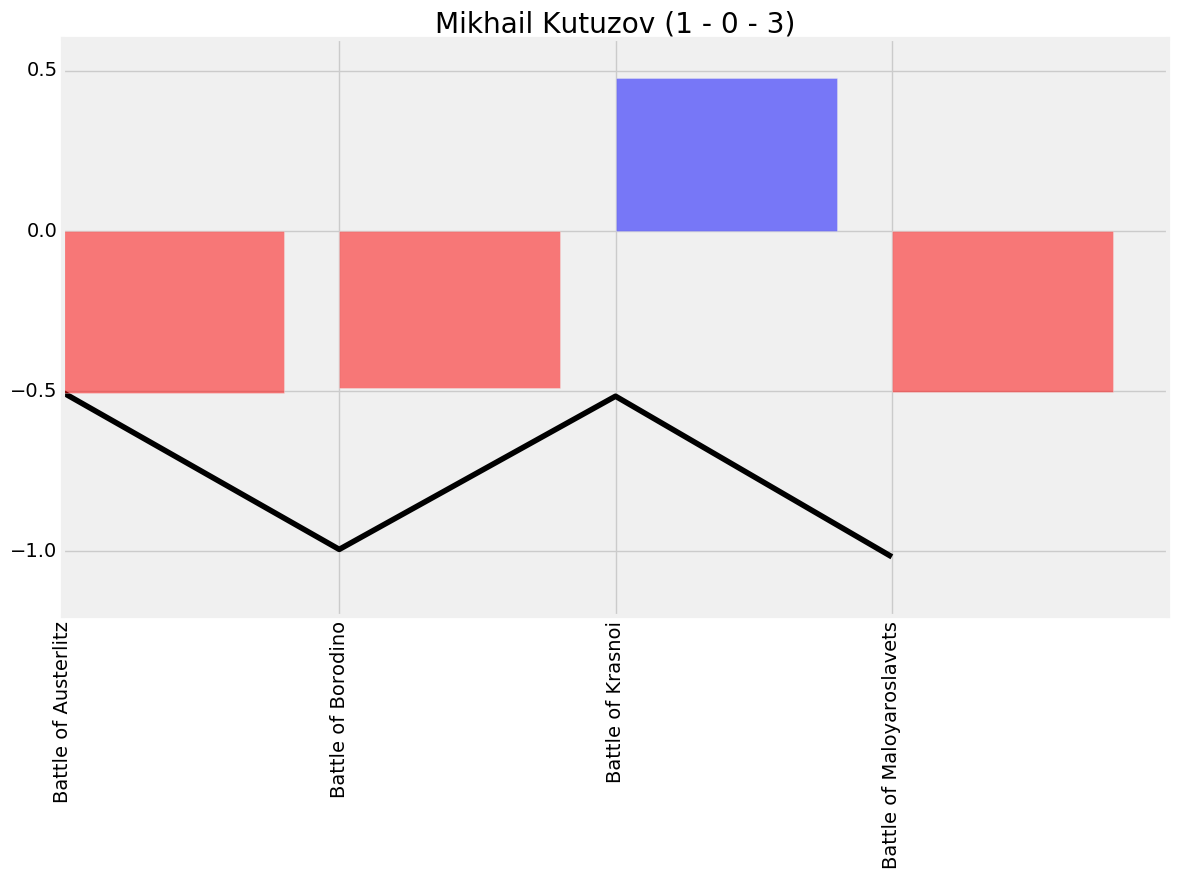

In [131]:
battle_list = []
graph('Mikhail Kutuzov')

In [132]:
df_battles

,Battle,General,Outcome,Value,Year,cumulative
0,Battle of Austerlitz,Mikhail Kutuzov,D,-0.503934,1805.0,-0.503934
1,Battle of Borodino,Mikhail Kutuzov,D,-0.489525,1812.0,-0.993459
2,Battle of Krasnoi,Mikhail Kutuzov,V,0.478066,1812.0,-0.515393
3,Battle of Maloyaroslavets,Mikhail Kutuzov,D,-0.501225,1812.0,-1.016618


In [ ]:
df_model[df_model.Battle == 'Battle_of_Borodino'].transpose()

In [ ]:
df_battles

In [ ]:
df_war = pd.DataFrame(war_list).sort('WAR', ascending = False).reset_index(drop = True)

In [ ]:
df_war.head()

In [133]:
df_totalwar = df_totalwar = df_totalwar[df_totalwar.General != 'Capital punishment']
df_totalwar = df_totalwar[df_totalwar.General != 'Lieutenant general']

In [134]:
df_totalwar[df_totalwar.General == 'Erwin Rommel']

,Battles,General,WAR
2579,8,Erwin Rommel,-1.923718


In [135]:
import seaborn as sns

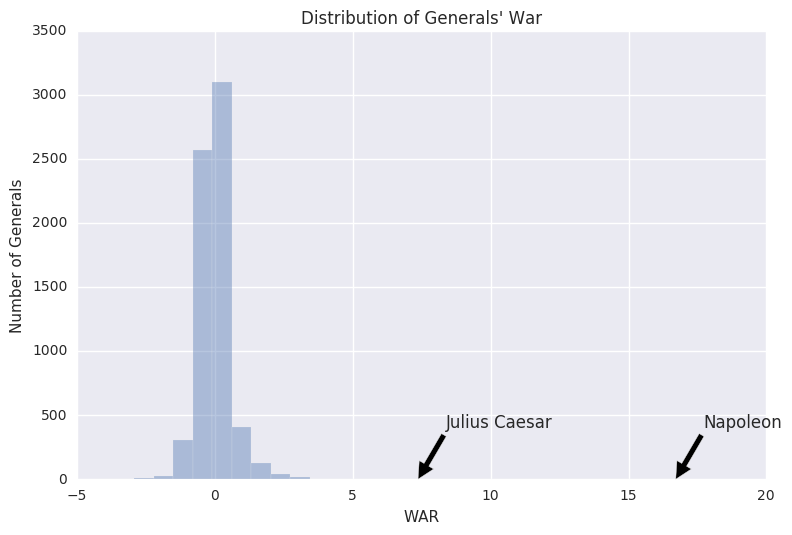

In [146]:
sns.distplot(df_totalwar['WAR'], kde = False, bins = 30)
plt.title("Distribution of Generals' War")
plt.ylabel('Number of Generals')
plt.annotate('Napoleon', xy = (16.713, 1), xytext = (17.713, 400), arrowprops = dict(facecolor = 'black'))
plt.annotate('Julius Caesar', xy = (7.364545, 1), xytext = (8.364545, 400), arrowprops = dict(facecolor = 'black'))
plt.tight_layout()
plt.savefig('/home/ethanarsht/Downloads/distplot.png')

In [ ]:
output_file('/home/ethanarsht/Downloads/google_doc_scatter_hover.html')
source = ColumnDataSource(data = dict(battles = df_totalwar.Battles,
                                      war = df_totalwar.WAR,
                                      general = df_totalwar.General))

hover = HoverTool(tooltips = [('General', '@general'),
                              ('Battles', '@battles'),
                              ('WAR', '@war'),
                                  ])
p = figure(title = 'WAR vs Number of Battles',
           plot_height = 600, 
           plot_width = 800,
          
           tools = [hover, "tap"])
p.circle(x = 'war', y = 'battles', size = 10, source = source)
p.xaxis.axis_label = 'WAR'
p.yaxis.axis_label = 'Battles'

url = "http://en.wikipedia.org/wiki/@general"
taptool = p.select(type=TapTool)
taptool.callback = OpenURL(url=url)
save(p)

In [ ]:
df_battles

In [ ]:
import math

In [ ]:
def bokeh(commander):
    battle_list = []
    df_battles = pd.DataFrame()
    commander_war(commander)

    df_battles.Year = df_battles.Year.fillna(-5000)
    df_battles.Year = df_battles.Year.astype(float, errors = 'ignore')
    df_battles = df_battles.sort('Year')
    wl = pd.DataFrame(df_battles.Outcome.value_counts())
    
    if 'V' in wl.index:
        wins = wl.loc['V', 'Outcome']
    else:
        wins = 0
    if 'D' in wl.index:
        losses = wl.loc['D', 'Outcome']
    else:
        losses = 0
    if 'I' in wl.index:
        draws = wl.loc['I', 'Outcome']
    else:
        draws = 0
    df_battles = df_battles.reset_index(drop = True)
    for i, row in df_battles.iterrows():
        df_battles.ix[i, 'cumulative'] = sum(df_battles.Value[0:i+1])
    global df_battles
    
    source = ColumnDataSource(data = dict(battle = df_battles.Battle,
                              general = df_battles.General,
                              outcome = df_battles.Outcome,
                              value = df_battles.Value,
                              year = df_battles.Year,
                              cumulative = df_battles.cumulative))
    if all(x != -5000 for x in df_battles.Year):
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative'),
                                  ('Year', '@year')])
    else:
        hover = HoverTool(tooltips = [('Battle', '@battle'),
                                  ('Outcome', '@outcome'),
                                  ('WAR', '@value'),
                                  ('Cumulative WAR', '@cumulative')
                                  ])
    
    x = list(df_battles.Battle)
    y = list(df_battles.Value)
    y_cum = list(df_battles.cumulative)
    
    output_file('{}_bokeh_warg.html'.format(commander))
    
    p = figure(title = commander + ' ({} - {} - {})'.format(wins, draws, losses), 
               plot_width=800, 
               plot_height=600, 
               x_range = x, 
               tools = [hover])
    
    p.line(x = x, y = y_cum, source = source, line_width = 5)
    
    color_mapper = CategoricalColorMapper(factors=['V', 'D', 'I'], palette=['Blue', 'Red', 'Yellow'])
    p.vbar(x = x, 
           top = y, 
           source = source, 
           width = 0.9, 
           color={'field': 'outcome', 'transform': color_mapper},
           alpha = 0.5)
    
    p.xaxis.major_label_orientation = math.pi/2
#     show(p)
    save(p)

In [ ]:
df_run[df_run.belligerent.str.contains('Khan')]

In [ ]:
mka = df_run.loc[8965, 'belligerent']

In [ ]:
mka

In [ ]:
battle_list = []
bokeh(u'Ulysses S. Grant')

In [ ]:
df_warchart = pd.DataFrame({'Labels': ['Win = 1', 'Replacement-Level Performance = .51', 'WAR From Battle = .49'],
              'Values': [1, .51, .49]})

In [ ]:
df_warchart = df_warchart.sort('Values', ascending = True)

In [ ]:
df_warchart

In [ ]:
df_warchart = df_warchart.iloc[::-1]

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart.index, df_warchart.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart.index + .5, df_warchart.Labels, rotation = 45)
plt.xticks()
plt.title("Bonaparte's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('napoleon_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
df_warchart_two = pd.DataFrame({'Labels': ['Win = -1', 'Replacement-Level Performance = .49', 'WAR From Battle = -.51'],
              'Values': [-1, -.49, -.51]})

In [ ]:
fig = plt.figure(figsize = (12,9))
plt.style.use('fivethirtyeight')
plt.bar(df_warchart_two.index, df_warchart_two.Values, width = 1, color = ['red', 'blue', 'yellow'])
plt.xticks(df_warchart_two.index + .5, df_warchart_two.Labels, rotation = 45)
plt.xticks()
plt.title("Kutuzov's WAR in Battle of Borodino")
plt.tight_layout()
plt.savefig('kutuzov_war_sample')

# ax.set_axis_bgcolor('gray')

In [ ]:
data = 

In [ ]:
probas = pd.DataFrame(lr.predict_proba(df_x))[1]

In [ ]:
df_y